In [1]:
#python notebook file which will contain the asset return predictions

## 1.Data Preparation

### 1.1. Importing Modules

In [2]:
import random
import os
import math
import warnings

import pandas as pd
import numpy as np
from numpy.random import seed 
import tensorflow as tf

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima

from keras_tuner import BayesianOptimization
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras import optimizers 
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.dates as mdates



/var/folders/d3/5_l3h7cd1c98_xcdw8_wgkbh0000gn/T/ipykernel_52205/3791328128.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
#setting seed for reproducability
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
# #general hyperparameter for lstm
# input_steps = 20
# output_steps = 1 #1-day ahead predictions

In [5]:
#general hyperparameter for lstm
input_steps = 20
output_steps = 5 #5-day ahead predictions

### 1.2. Defining Functions

In [6]:
#function - creating two sequence out of which one predicts the other (from: https://github.com/krishnaik06/Time-Series-Forecasting/blob/master/UnivariateTimeSeries.ipynb)
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

### 1.3. Loading Data

In [7]:
# Initialize an empty dictionary to store the loaded DataFrames
data_dict = {}

# Define the directory where the CSV files are saved
directory = '/Users/cemakkus/PycharmProjects/Master/data/'

# Iterate through each file in the directory
for filename in os.listdir(directory):
    if filename.startswith('export_') and filename.endswith('.csv'):
        # Extract the ticker from the filename
        ticker = filename.replace('export_', '').replace('.csv', '')
        
        # Define the full file path
        file_path = os.path.join(directory, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        data_dict[ticker] = df.iloc[output_steps:]  # Select all rows except the last rows that contain nan's
        
        
        print(f'DataFrame for {ticker} loaded from {file_path}')


# At this point, data_dict contains all DataFrames, keyed and sorted by ticker
data_dict = {k: data_dict[k] for k in sorted(data_dict)}


DataFrame for SAF_PA loaded from /Users/cemakkus/PycharmProjects/Master/data/export_SAF_PA.csv
DataFrame for MUV2_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/export_MUV2_DE.csv
DataFrame for ISP_MI loaded from /Users/cemakkus/PycharmProjects/Master/data/export_ISP_MI.csv
DataFrame for ASML_AS loaded from /Users/cemakkus/PycharmProjects/Master/data/export_ASML_AS.csv
DataFrame for BN_PA loaded from /Users/cemakkus/PycharmProjects/Master/data/export_BN_PA.csv
DataFrame for BBVA_MC loaded from /Users/cemakkus/PycharmProjects/Master/data/export_BBVA_MC.csv
DataFrame for CRH loaded from /Users/cemakkus/PycharmProjects/Master/data/export_CRH.csv
DataFrame for ITX_MC loaded from /Users/cemakkus/PycharmProjects/Master/data/export_ITX_MC.csv
DataFrame for BAYN_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/export_BAYN_DE.csv
DataFrame for DB1_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/export_DB1_DE.csv
DataFrame for ADS_DE loaded from /Users/cemakkus/P

### 1.4. Feature Engineering for LSTM

In [8]:
#hyperparameter for feature engineering (at this part of the code, so models use exactly the same dates for their predictions)
n_features = 2
window = 10

In [9]:
data_dict['SAP_DE']

,date,company,ISIN,positive,negative,sentiment,volume,esg_score,e_score,s_score,g_score,general_risk_score,esg_risk_score,credit_risk_score,immediate_risk_score,Close,1d_return,5d_return
5,2020-01-09,company:sap,DE0007164600,614.000000,35.000000,0.944700,1096.000000,3.770033,5.163344,5.395474,4.003451,7.204727,6.419041,7.499171,4.302945,123.160004,0.019368,0.009508
6,2020-01-10,company:sap,DE0007164600,220.333333,20.666667,0.915289,356.000000,3.882201,5.140076,5.491914,4.097236,6.656833,5.794524,7.014651,3.942386,123.760002,0.004872,0.027395
7,2020-01-13,company:sap,DE0007164600,573.000000,22.000000,0.961474,999.000000,3.956627,5.123488,5.579818,4.152788,6.053848,5.118360,6.506249,3.717639,123.760002,0.000000,0.035129
8,2020-01-14,company:sap,DE0007164600,642.000000,44.000000,0.934593,1139.000000,3.968709,5.119384,5.614463,4.169690,5.756650,4.832103,6.292197,3.669219,123.599998,-0.001293,0.029142
9,2020-01-15,company:sap,DE0007164600,438.000000,41.000000,0.912682,1007.000000,3.995202,5.113659,5.633509,4.199947,5.454003,4.519858,0.000000,3.627436,123.000000,-0.004854,0.018043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,2024-01-11,company:sap,DE0007164600,488.000000,223.000000,0.685835,1033.000000,3.025249,5.857778,4.460554,3.097214,6.274508,5.378073,6.881363,6.720926,141.880005,-0.001126,0.039871
1024,2024-01-12,company:sap,DE0007164600,161.000000,22.000000,0.899605,263.333333,2.376450,5.739723,4.568529,2.363558,7.290106,6.562143,7.665291,7.895203,144.860001,0.021004,0.056755
1025,2024-01-15,company:sap,DE0007164600,321.000000,56.000000,0.849604,610.000000,1.995999,5.667875,4.624281,1.955280,7.832766,7.206568,8.131393,8.418424,144.559998,-0.002071,0.041649
1026,2024-01-16,company:sap,DE0007164600,270.000000,53.000000,0.833846,623.000000,1.770061,5.667872,4.602855,1.730381,8.191230,7.620967,8.434507,8.704681,144.580002,0.000138,0.038053


In [10]:
# Iterate through each item in the dictionary
for ticker, df in data_dict.items():
    # Check if '1d_return' column exists in the DataFrame
    if '1d_return' in df.columns:
        # Directly calculate and assign rolling mean and standard deviation to new columns
        df['Rolling_Mean'] = df['1d_return'].rolling(window=window).mean()
        df['Rolling_Std'] = df['1d_return'].rolling(window=window).std()

        # Disregard the initial rows where rolling metrics cannot be calculated
        df = df.iloc[window-1:].reset_index(drop=True)

        # Update the DataFrame in the dictionary
        data_dict[ticker] = df
        print(f'Updated DataFrame for {ticker} by adding rolmean and rolstd and disregarding initial {window-1} rows')


Updated DataFrame for ABI_BR by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for ADS_DE by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for ADYEN_AS by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for AD_AS by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for AIR_PA by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for AI_PA by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for ALV_DE by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for ASML_AS by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for BAS_DE by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for BAYN_DE by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for BBVA_MC by adding rolmean and rolstd and disregarding initial 9 rows
Updated

In [11]:
data_dict['SAP_DE']

,date,company,ISIN,positive,negative,sentiment,volume,esg_score,e_score,s_score,g_score,general_risk_score,esg_risk_score,credit_risk_score,immediate_risk_score,Close,1d_return,5d_return,Rolling_Mean,Rolling_Std
0,2020-01-22,company:sap,DE0007164600,720.000000,57.000000,0.925546,1188.000000,3.926014,5.348326,5.625235,4.184493,5.291100,4.375904,5.970151,4.042344,126.599998,0.003170,0.029268,0.004737,0.010960
1,2020-01-23,company:sap,DE0007164600,610.000000,97.000000,0.861777,1084.000000,5.653542,5.487818,5.624037,4.202409,5.168855,4.211336,5.882165,4.035560,123.839996,-0.021801,0.011434,0.000620,0.012480
2,2020-01-24,company:sap,DE0007164600,225.333333,19.666667,0.911759,373.000000,5.905134,5.742564,5.674352,4.165297,5.156700,4.163391,5.942828,4.241408,126.900002,0.024709,0.007463,0.002604,0.014624
3,2020-01-27,company:sap,DE0007164600,511.000000,54.000000,0.902998,1095.000000,6.077263,5.929031,5.680845,4.168613,5.041335,4.011898,0.000000,4.284347,122.459999,-0.034988,-0.025466,-0.000895,0.018882
4,2020-01-28,company:sap,DE0007164600,1441.000000,1215.000000,0.542513,3550.000000,5.762112,5.725850,5.381126,4.388157,4.938853,3.531990,5.941445,3.686046,119.839996,-0.021395,-0.050396,-0.002905,0.019968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,2024-01-11,company:sap,DE0007164600,488.000000,223.000000,0.685835,1033.000000,3.025249,5.857778,4.460554,3.097214,6.274508,5.378073,6.881363,6.720926,141.880005,-0.001126,0.039871,0.001491,0.009583
1010,2024-01-12,company:sap,DE0007164600,161.000000,22.000000,0.899605,263.333333,2.376450,5.739723,4.568529,2.363558,7.290106,6.562143,7.665291,7.895203,144.860001,0.021004,0.056755,0.003734,0.011296
1011,2024-01-15,company:sap,DE0007164600,321.000000,56.000000,0.849604,610.000000,1.995999,5.667875,4.624281,1.955280,7.832766,7.206568,8.131393,8.418424,144.559998,-0.002071,0.041649,0.003641,0.011344
1012,2024-01-16,company:sap,DE0007164600,270.000000,53.000000,0.833846,623.000000,1.770061,5.667872,4.602855,1.730381,8.191230,7.620967,8.434507,8.704681,144.580002,0.000138,0.038053,0.005189,0.009345


### 1.5. Pre-Processing for ARIMA (Determining Best ARIMA models & Generating Train/Test Sets)

In [12]:
#hyperparameter for train/test split
train_test_ratio = 0.8

In [13]:
for ticker, df in data_dict.items():
    # Check if 'date' column exists in the DataFrame
    if 'date' in df.columns:
        # Convert 'date' column to datetime
        df['date'] = pd.to_datetime(df['date'])
        # Set the 'date' column as the index
        df = df.set_index('date')
        # Update the DataFrame in the dictionary
        data_dict[ticker] = df
        print(f'Updated DataFrame for {ticker} with date as index')


Updated DataFrame for ABI_BR with date as index
Updated DataFrame for ADS_DE with date as index
Updated DataFrame for ADYEN_AS with date as index
Updated DataFrame for AD_AS with date as index
Updated DataFrame for AIR_PA with date as index
Updated DataFrame for AI_PA with date as index
Updated DataFrame for ALV_DE with date as index
Updated DataFrame for ASML_AS with date as index
Updated DataFrame for BAS_DE with date as index
Updated DataFrame for BAYN_DE with date as index
Updated DataFrame for BBVA_MC with date as index
Updated DataFrame for BMW_DE with date as index
Updated DataFrame for BNP_PA with date as index
Updated DataFrame for BN_PA with date as index
Updated DataFrame for CRH with date as index
Updated DataFrame for CS_PA with date as index
Updated DataFrame for DB1_DE with date as index
Updated DataFrame for DG_PA with date as index
Updated DataFrame for DHL_DE with date as index
Updated DataFrame for DTE_DE with date as index
Updated DataFrame for EL_PA with date as in

In [14]:
data_dict['SAP_DE']['1d_return']

date
2020-01-22    0.003170
2020-01-23   -0.021801
2020-01-24    0.024709
2020-01-27   -0.034988
2020-01-28   -0.021395
                ...   
2024-01-11   -0.001126
2024-01-12    0.021004
2024-01-15   -0.002071
2024-01-16    0.000138
2024-01-17    0.001660
Name: 1d_return, Length: 1014, dtype: float64

In [15]:
# Initialize dictionaries to store the train and test sets for each ticker
train_dict_arima = {}
test_dict_arima = {}

for ticker, df in data_dict.items():
    # Check if '1d_return' column exists in the DataFrame
    if '1d_return' in df.columns:
        # Perform train-test split
        train, test = train_test_split(df['1d_return'], test_size=1-train_test_ratio, shuffle=False)
        
        # Store the train and test sets in the respective dictionaries
        train_dict_arima[ticker] = train
        test_dict_arima[ticker] = test
        
        print(f'Train and test sets created for {ticker}')

Train and test sets created for ABI_BR
Train and test sets created for ADS_DE
Train and test sets created for ADYEN_AS
Train and test sets created for AD_AS
Train and test sets created for AIR_PA
Train and test sets created for AI_PA
Train and test sets created for ALV_DE
Train and test sets created for ASML_AS
Train and test sets created for BAS_DE
Train and test sets created for BAYN_DE
Train and test sets created for BBVA_MC
Train and test sets created for BMW_DE
Train and test sets created for BNP_PA
Train and test sets created for BN_PA
Train and test sets created for CRH
Train and test sets created for CS_PA
Train and test sets created for DB1_DE
Train and test sets created for DG_PA
Train and test sets created for DHL_DE
Train and test sets created for DTE_DE
Train and test sets created for EL_PA
Train and test sets created for ENEL_MI
Train and test sets created for ENI_MI
Train and test sets created for FLTR_L
Train and test sets created for IBE_MC
Train and test sets created 

In [16]:
train_dict_arima['SAP_DE']

date
2020-01-22    0.003170
2020-01-23   -0.021801
2020-01-24    0.024709
2020-01-27   -0.034988
2020-01-28   -0.021395
                ...   
2023-03-17   -0.009410
2023-03-20    0.012189
2023-03-21    0.007969
2023-03-22   -0.000527
2023-03-23    0.007910
Name: 1d_return, Length: 811, dtype: float64

In [17]:
test_dict_arima['SAP_DE']

date
2023-03-24   -0.006104
2023-03-27    0.003334
2023-03-28   -0.005422
2023-03-29    0.007561
2023-03-30    0.006632
                ...   
2024-01-11   -0.001126
2024-01-12    0.021004
2024-01-15   -0.002071
2024-01-16    0.000138
2024-01-17    0.001660
Name: 1d_return, Length: 203, dtype: float64

In [18]:
# Initialize a dictionary to store the auto ARIMA results
autoarima_dict = {}

for ticker, train_series in train_dict_arima.items():
    print(f"Running auto ARIMA for {ticker}...")
    model = auto_arima(train_series, 
                       start_p=0, start_q=0,  # minimum p and q
                       test='adf',            # use augmented dickey-fuller test to find optimal 'd'
                       max_p=3, max_q=3,      # maximum p and q
                       d=None,                # let model determine 'd'
                       seasonal=False,        # no seasonality
                       trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)
    
    # Store the model or its parameters in the dictionary
    autoarima_dict[ticker] = model
    print(f"Auto ARIMA for {ticker} completed.")

Running auto ARIMA for ABI_BR...


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3842.723, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-3840.741, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-3840.741, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3838.741, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-3840.724, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.315 seconds
Auto ARIMA for ABI_BR completed.
Running auto ARIMA for ADS_DE...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3673.736, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-3672.416, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-3672.391, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3670.642, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-3672.287, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.279 seconds
Auto ARIMA for ADS_DE co

In [19]:
for ticker, train_series in train_dict_arima.items():
    print(f"Best ARIMA model for {ticker}: {autoarima_dict[ticker].order}")

Best ARIMA model for ABI_BR: (0, 0, 0)
Best ARIMA model for ADS_DE: (0, 0, 0)
Best ARIMA model for ADYEN_AS: (0, 0, 0)
Best ARIMA model for AD_AS: (0, 0, 0)
Best ARIMA model for AIR_PA: (2, 0, 2)
Best ARIMA model for AI_PA: (1, 0, 1)
Best ARIMA model for ALV_DE: (2, 0, 0)
Best ARIMA model for ASML_AS: (0, 0, 0)
Best ARIMA model for BAS_DE: (0, 0, 0)
Best ARIMA model for BAYN_DE: (2, 0, 1)
Best ARIMA model for BBVA_MC: (0, 0, 0)
Best ARIMA model for BMW_DE: (1, 0, 0)
Best ARIMA model for BNP_PA: (0, 0, 0)
Best ARIMA model for BN_PA: (0, 0, 0)
Best ARIMA model for CRH: (0, 0, 0)
Best ARIMA model for CS_PA: (2, 0, 0)
Best ARIMA model for DB1_DE: (2, 0, 0)
Best ARIMA model for DG_PA: (1, 0, 0)
Best ARIMA model for DHL_DE: (0, 0, 1)
Best ARIMA model for DTE_DE: (3, 0, 0)
Best ARIMA model for EL_PA: (0, 0, 0)
Best ARIMA model for ENEL_MI: (0, 0, 0)
Best ARIMA model for ENI_MI: (0, 0, 0)
Best ARIMA model for FLTR_L: (0, 0, 0)
Best ARIMA model for IBE_MC: (2, 0, 0)
Best ARIMA model for IFX_DE:

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4145.598, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-4146.833, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-4146.369, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-4149.845, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-4148.195, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-4148.684, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4147.146, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-4146.238, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-4147.853, Time=0.03 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 0.542 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  811
Model:               SARIMAX(2, 0, 0)   Log Likelihood                2077.922
Date:                Wed, 13 Mar 2024   

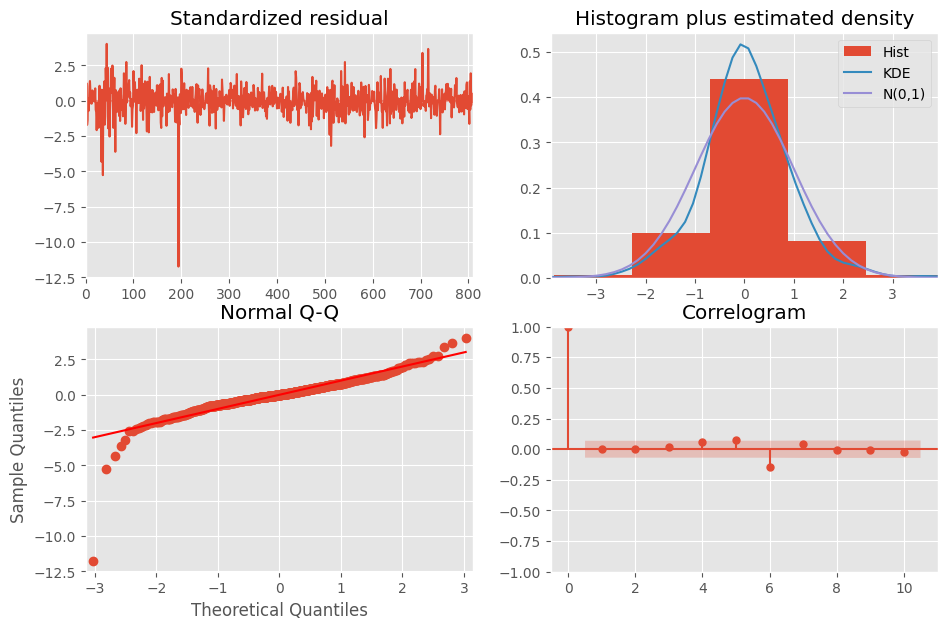

In [20]:
#example with summary and plot
#determining most suitable arima order for sap prediction
autoarima_SAP = auto_arima(train_dict_arima['SAP_DE'], 
                      start_p=0, start_q=0,  #minimum p and q
                      test='adf',            #use augmented dickey-fuller test to find optimal 'd'
                      max_p=3, max_q=3,      #maximum p and q
                      d=None,                #let model determine 'd'
                      seasonal=False,        #no seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(autoarima_SAP.summary())
autoarima_SAP.plot_diagnostics(figsize=(11,7))
plt.show()

### 1.6. Pre-Processing for LSTM (Splitting Sequences & Generating Train/Test Sets)

In [21]:
# #general hyperparameter
# input_steps = 20
# output_steps = 5 # day ahead prediction

In [22]:
# Initialize dictionaries to store the LSTM input and output sequences for training, validation, and testing
X_train_dict, Y_train_dict = {}, {}
X_val_dict, Y_val_dict = {}, {}
X_test_dict, Y_test_dict = {}, {}

def prepare_sequences(X_seq, Y_seq, n_features, input_steps):
    # Ensure concatenation is done similarly to Method 1
    X_reshaped = np.concatenate([X_seq[0], X_seq[1], X_seq[2]])  # Concatenate along feature axis
    X_reshaped = np.reshape(X_reshaped, (int(X_reshaped.shape[0]/(n_features+1)), input_steps, n_features + 1), order='F')
    Y_reshaped = np.array([y[output_steps - 1] for y in Y_seq])
    return X_reshaped, Y_reshaped

# Loop through each ticker in the data dictionary
for ticker, df in data_dict.items():
    if '1d_return' in df.columns and 'Rolling_Mean' in df.columns and 'Rolling_Std' in df.columns:
        # Generate sequences for each feature and the target
        X_seq = split_sequence(df['1d_return'].values, input_steps, output_steps)
        X1_seq = split_sequence(df['Rolling_Mean'].values, input_steps, output_steps)
        X2_seq = split_sequence(df['Rolling_Std'].values, input_steps, output_steps)
        
        # Concatenate and reshape sequences
        #X_ft, Y = prepare_sequences([X_seq[0], X1_seq[0], X2_seq[0]], X_seq[1], n_features)
        # Corrected function call with all required arguments
        X_ft, Y = prepare_sequences([X_seq[0], X1_seq[0], X2_seq[0]], X_seq[1], n_features, input_steps)

        
        # Split into train, validation, and test sets
        X_temp, X_test, Y_temp, Y_test = train_test_split(X_ft, Y, test_size=0.2, shuffle=False)
        X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.25, shuffle=False)
        
        # Store in dictionaries
        X_train_dict[ticker] = X_train
        Y_train_dict[ticker] = Y_train
        X_val_dict[ticker] = X_val
        Y_val_dict[ticker] = Y_val
        X_test_dict[ticker] = X_test
        Y_test_dict[ticker] = Y_test

# Now, X_train_dict, Y_train_dict, X_val_dict, Y_val_dict, X_test_dict, and Y_test_dict 
# contain the train, validation, and test sets for each ticker, respectively.

In [23]:
data_dict['SAP_DE']

,company,ISIN,positive,negative,sentiment,volume,esg_score,e_score,s_score,g_score,general_risk_score,esg_risk_score,credit_risk_score,immediate_risk_score,Close,1d_return,5d_return,Rolling_Mean,Rolling_Std
date,,,,,,,,,,,,,,,,,,,
2020-01-22,company:sap,DE0007164600,720.000000,57.000000,0.925546,1188.000000,3.926014,5.348326,5.625235,4.184493,5.291100,4.375904,5.970151,4.042344,126.599998,0.003170,0.029268,0.004737,0.010960
2020-01-23,company:sap,DE0007164600,610.000000,97.000000,0.861777,1084.000000,5.653542,5.487818,5.624037,4.202409,5.168855,4.211336,5.882165,4.035560,123.839996,-0.021801,0.011434,0.000620,0.012480
2020-01-24,company:sap,DE0007164600,225.333333,19.666667,0.911759,373.000000,5.905134,5.742564,5.674352,4.165297,5.156700,4.163391,5.942828,4.241408,126.900002,0.024709,0.007463,0.002604,0.014624
2020-01-27,company:sap,DE0007164600,511.000000,54.000000,0.902998,1095.000000,6.077263,5.929031,5.680845,4.168613,5.041335,4.011898,0.000000,4.284347,122.459999,-0.034988,-0.025466,-0.000895,0.018882
2020-01-28,company:sap,DE0007164600,1441.000000,1215.000000,0.542513,3550.000000,5.762112,5.725850,5.381126,4.388157,4.938853,3.531990,5.941445,3.686046,119.839996,-0.021395,-0.050396,-0.002905,0.019968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-11,company:sap,DE0007164600,488.000000,223.000000,0.685835,1033.000000,3.025249,5.857778,4.460554,3.097214,6.274508,5.378073,6.881363,6.720926,141.880005,-0.001126,0.039871,0.001491,0.009583
2024-01-12,company:sap,DE0007164600,161.000000,22.000000,0.899605,263.333333,2.376450,5.739723,4.568529,2.363558,7.290106,6.562143,7.665291,7.895203,144.860001,0.021004,0.056755,0.003734,0.011296
2024-01-15,company:sap,DE0007164600,321.000000,56.000000,0.849604,610.000000,1.995999,5.667875,4.624281,1.955280,7.832766,7.206568,8.131393,8.418424,144.559998,-0.002071,0.041649,0.003641,0.011344


In [24]:
X_train_dict['SAP_DE']

array([[[ 0.00316958,  0.02040749,  0.00106743],
        [ 0.00473733, -0.00304621,  0.01430236],
        [ 0.01095982, -0.00652671,  0.01374735],
        ...,
        [ 0.01999633, -0.0020929 , -0.00062796],
        [-0.01516666,  0.01832219,  0.00349452],
        [-0.00334722, -0.0033849 ,  0.00673992]],

       [[-0.02180097,  0.01705233,  0.00458164],
        [ 0.00062046,  0.0185028 ,  0.01235471],
        [ 0.01248023, -0.00443827,  0.01164645],
        ...,
        [ 0.02040749,  0.00106743,  0.01665098],
        [-0.00304621,  0.01430236,  0.00384233],
        [-0.00652671,  0.01374735,  0.00735642]],

       [[ 0.02470934,  0.01880519,  0.00561278],
        [ 0.00260423,  0.02483336,  0.01248327],
        [ 0.01462363, -0.00238466, -0.00015768],
        ...,
        [ 0.01705233,  0.00458164, -0.01266996],
        [ 0.0185028 ,  0.01235471,  0.0027198 ],
        [-0.00443827,  0.01164645,  0.00893902]],

       ...,

       [[-0.01387974,  0.01308412,  0.00268972],
        [-0

In [25]:
#creating two sequence out of which one predicts the other - asset return of dax
X_SAP,Y_SAP = split_sequence(data_dict['SAP_DE']['1d_return'], input_steps, output_steps)

#creating two sequence out of which one predicts the other - features of SAP
X1_SAP,Y1_SAP = split_sequence(data_dict['SAP_DE']['Rolling_Mean'], input_steps, output_steps)

X2_SAP,Y2_SAP = split_sequence(data_dict['SAP_DE']['Rolling_Std'], input_steps, output_steps)

#concatenating input variables for lstm
X_ft_SAP = np.concatenate([X_SAP,X1_SAP,X2_SAP])

#reshaping
#X_SAP = np.reshape(X_SAP, (X_SAP.shape[0], input_steps, 1), order='F')
X_ft_SAP = np.reshape(X_ft_SAP, (int(X_ft_SAP.shape[0]/(n_features+1)), input_steps, n_features + 1), order='F')
Y_SAP = np.reshape(Y_SAP, (Y_SAP.shape[0], output_steps), order='F')

#bringing Y in array form
Y_SAP = [i[output_steps - 1] for i in Y_SAP.tolist()]
Y_SAP = np.array(Y_SAP)

# #splitting sequence into train and test data
# X_ft_train_SAP, X_ft_test_SAP, Y_train_SAP, Y_test_SAP = train_test_split(X_ft_SAP, Y_SAP, test_size=1-train_test_ratio, shuffle = False) #with features

#splitting sequence into train, val and test data (60-20-20 split)
# First split: Separate out the test set
X_temp, X_ft_test_SAP, Y_temp, Y_test_SAP = train_test_split(X_ft_SAP, Y_SAP, test_size=1-train_test_ratio, shuffle=False)
# Second split: Split the remaining data into training and validation sets
X_ft_train_SAP, X_ft_val_SAP, Y_train_SAP, Y_val_SAP = train_test_split(X_temp, Y_temp, test_size=0.25, shuffle=False)  # 0.25 * 0.8 = 0.2 # 0.1765 * 0.85 = 0.15

In [26]:
X_ft_SAP = np.concatenate([X_SAP,X1_SAP,X2_SAP])
X_ft_SAP.shape

(2970, 20)

In [27]:
X_train_dict['SAP_DE'].shape

(594, 20, 3)

## 2. LSTM & ARIMA: 5-Day Ahead Predictions

### 2.1 LSTM Model & Prediction

In [28]:
#hyperparameter for lstm
epochs = 50
max_trials = 20
patience = 10
verbose = 1

In [29]:
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [30]:
def lstm_model(hp):
    model_LSTM = tf.keras.Sequential()
    model_LSTM.add(LSTM(
        units=hp.Int('units', min_value=8, max_value=64, step=8),
        #activation = hp.Choice("activation", values = ["sigmoid", "tanh", "relu"]),
        return_sequences=False,
        input_shape=(input_steps, n_features + 1)))
    model_LSTM.add(Dense(1))
    
    # Setting learning rate within the optimizer configuration
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    #optimizer = optimizers.Adam(learning_rate=learning_rate)
    optimizer = Adam(learning_rate=learning_rate) #legacy Adam
    
    model_LSTM.compile(optimizer=optimizer, loss='mse')
    return model_LSTM

In [31]:
tuner = BayesianOptimization(
    lstm_model,
    objective='val_loss',
    max_trials=20,  # Number of trials to run
    executions_per_trial=1,  # Number of models that should be built and fit for each trial
    directory='directory',  # Directory to save logs and models
    project_name='project',
    overwrite = True
)

In [32]:
tuner.search(X_train_dict['SAP_DE'], Y_train_dict['SAP_DE'],
             epochs=50,
             validation_data=(X_val_dict['SAP_DE'], Y_val_dict['SAP_DE']),
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

Trial 20 Complete [00h 00m 02s]
val_loss: 0.00024158191808965057

Best val_loss So Far: 0.00024110412050504237
Total elapsed time: 00h 00m 37s


In [33]:
# best hyperparameters
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_hyperparameters = best_trial.hyperparameters.values

# print the best hyperparameters
print("Best Hyperparameters:")
for key, value in best_hyperparameters.items():
    print(f"{key}: {value}")


Best Hyperparameters:
units: 24
learning_rate: 0.00028738551380345044


In [34]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history_LSTM_SAP = best_model.fit(X_train_dict['SAP_DE'], Y_train_dict['SAP_DE'], callbacks=[early_stopping], epochs=epochs, verbose=verbose, validation_data=(X_val_dict['SAP_DE'], Y_val_dict['SAP_DE']))

# Predicting values for SAP asset returns
yhat_SAP = best_model.predict(X_test_dict['SAP_DE'])

Epoch 1/50
19/19 [==============================] - 1s 13ms/step - loss: 3.8697e-04 - val_loss: 2.4176e-04
Epoch 2/50
19/19 [==============================] - 0s 3ms/step - loss: 3.9051e-04 - val_loss: 2.5667e-04
Epoch 3/50
19/19 [==============================] - 0s 3ms/step - loss: 3.9379e-04 - val_loss: 2.4098e-04
Epoch 4/50
19/19 [==============================] - 0s 3ms/step - loss: 3.8699e-04 - val_loss: 2.4591e-04
Epoch 5/50
19/19 [==============================] - 0s 3ms/step - loss: 3.8520e-04 - val_loss: 2.4429e-04
Epoch 6/50
19/19 [==============================] - 0s 3ms/step - loss: 3.8452e-04 - val_loss: 2.4180e-04
Epoch 7/50
19/19 [==============================] - 0s 3ms/step - loss: 3.8642e-04 - val_loss: 2.4584e-04
Epoch 8/50
19/19 [==============================] - 0s 3ms/step - loss: 3.8722e-04 - val_loss: 2.4114e-04
Epoch 9/50
19/19 [==============================] - 0s 3ms/step - loss: 3.8503e-04 - val_loss: 2.4580e-04
Epoch 10/50
19/19 [==========================

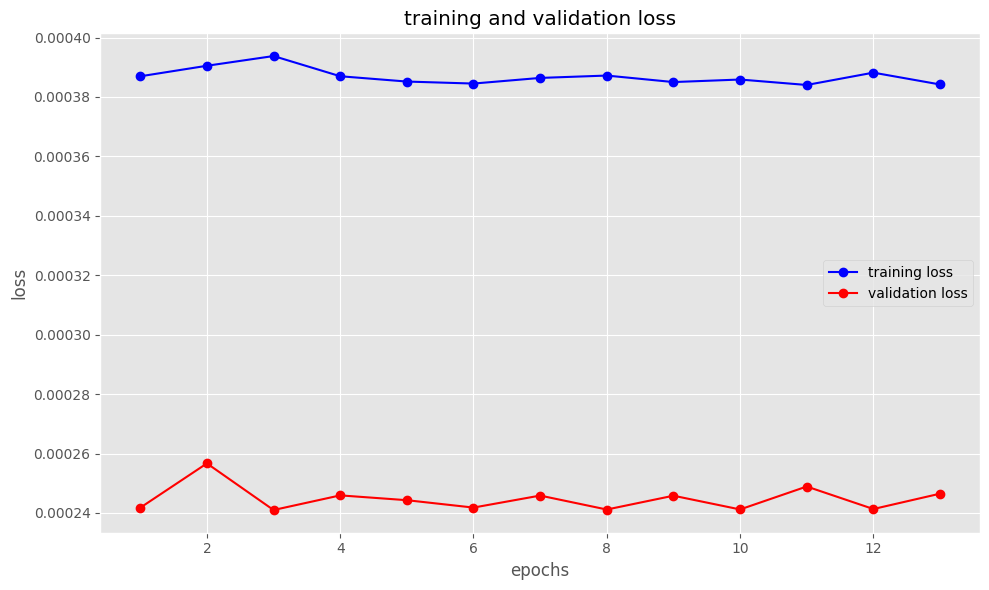

In [35]:
#plot - loss of lstm sap prediction
train_loss = history_LSTM_SAP.history['loss']
val_loss = history_LSTM_SAP.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='training loss')
plt.plot(epochs, val_loss, 'ro-', label='validation loss')
plt.title('training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.tight_layout()


In [36]:
#bringing yhat in flat form
#yhat_reshape_SAP = yhat_SAP.reshape(-1,1).reshape(-1,1)
yhat_flat_SAP = [item for sublist in yhat_SAP.tolist() for item in sublist]

#review performance of sap lstm
mse_LSTM = mean_squared_error(yhat_flat_SAP, Y_test_SAP)
print('MSE_LSTM: '+str("{:e}".format(mse_LSTM)))
mae_LSTM = mean_absolute_error(yhat_flat_SAP, Y_test_SAP)
print('MAE_LSTM: '+str("{:e}".format(mae_LSTM)))
rmse_LSTM = math.sqrt(mean_squared_error(yhat_flat_SAP, Y_test_SAP))
print('RMSE_LSTM: '+str("{:e}".format(rmse_LSTM)))

MSE_LSTM: 1.520865e-04
MAE_LSTM: 8.912581e-03
RMSE_LSTM: 1.233233e-02


In [37]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24)                2688      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 2713 (10.60 KB)
Trainable params: 2713 (10.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
#new new code starts here

In [39]:
#hyperparameter for lstm
epochs = 50
max_trials = 20
patience = 10
verbose = 1

In [40]:
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [41]:
# Function to create an LSTM model with dynamic hyperparameters
def create_lstm_model(input_steps, n_features, units, learning_rate):
    model = tf.keras.Sequential([
        LSTM(units=units, return_sequences=False, input_shape=(input_steps, n_features + 1)),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [42]:
import io
from contextlib import redirect_stdout

def get_model_summary(model):
    with io.StringIO() as buf, redirect_stdout(buf):
        model.summary()
        return buf.getvalue()  # Returns the model summary as a string.


In [43]:
# Function to perform hyperparameter tuning
def lstm_hp(X_train, Y_train, X_val, Y_val, input_steps, n_features, company_name, epochs, max_trials):
    def model_builder(hp):
        units = hp.Int('units', min_value=8, max_value=64, step=8)
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        model = create_lstm_model(input_steps, n_features, units, learning_rate)
        return model

    tuner = BayesianOptimization(
        model_builder,
        objective='val_loss',
        max_trials=max_trials,
        executions_per_trial=1,
        directory=f'./lstm_tuning/{company_name}',
        project_name='lstm_hyperparameter_tuning',
        overwrite=True
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    tuner.search(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val), callbacks=[early_stopping])

    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
    return best_hyperparameters

In [44]:
def train_final_lstm_model(X_train, Y_train, X_val, Y_val, best_hyperparameters, input_steps, n_features, epochs, patience, verbose):
    units = best_hyperparameters.get('units')
    learning_rate = best_hyperparameters.get('learning_rate')
    model = create_lstm_model(input_steps, n_features, units, learning_rate)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
    history = model.fit(X_train, Y_train, epochs=epochs, verbose=verbose, validation_data=(X_val, Y_val), callbacks=[early_stopping])
    
    return model, history


In [45]:
#hp_lstm = {}
results_lstm = {}  # Ensure this is initialized outside the loop

for company_name, X_train in X_train_dict.items():
    Y_train = Y_train_dict[company_name]
    X_val = X_val_dict[company_name]
    Y_val = Y_val_dict[company_name]
    input_steps = X_train.shape[1]
    n_features = X_train.shape[2]  # Assuming the target feature has already been excluded

    # Perform hyperparameter tuning to find the best model parameters
    print(f"Hyperparameter tuning for {company_name}...")
    best_hyperparameters = lstm_hp(X_train, Y_train, X_val, Y_val, input_steps, n_features - 1, company_name, epochs, max_trials=20)  # Ensure n_features is correctly adjusted if needed

    # Train the final model with the best hyperparameters
    print(f"Final training and prediction for {company_name}...")
    model, history = train_final_lstm_model(X_train, Y_train, X_val, Y_val, best_hyperparameters, input_steps, n_features - 1, epochs, patience, verbose)
    model_summary = get_model_summary(model)

    # Predict and flatten the output
    yhat = model.predict(X_test_dict[company_name])
    yhat_flat = [item for sublist in yhat.tolist() for item in sublist]

    # Calculate performance metrics
    mse = mean_squared_error(Y_test_dict[company_name], yhat_flat)
    mae = mean_absolute_error(Y_test_dict[company_name], yhat_flat)
    rmse = math.sqrt(mse)

    # Store predictions, metrics, and training history
    results_lstm[company_name] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'Predictions': yhat_flat,
        'History': history.history,  # Store the training and validation loss over epochs
        'Summary': model_summary
    }

    print(f'{company_name} - MSE: {mse:e}, MAE: {mae:e}, RMSE: {rmse:e}')

# Visualization or further analysis of training and validation loss can now be done using the 'History' key in results_lstm


Trial 20 Complete [00h 00m 27s]
val_loss: 0.0005333723383955657

Best val_loss So Far: 0.0005287521053105593
Total elapsed time: 00h 08m 34s
Final training and prediction for VOW3_DE...
Epoch 1/50
19/19 [==============================] - 5s 54ms/step - loss: 8.0366e-04 - val_loss: 5.3657e-04
Epoch 2/50
19/19 [==============================] - 0s 3ms/step - loss: 8.0417e-04 - val_loss: 5.3262e-04
Epoch 3/50
19/19 [==============================] - 0s 3ms/step - loss: 8.0002e-04 - val_loss: 5.3176e-04
Epoch 4/50
19/19 [==============================] - 0s 3ms/step - loss: 7.9868e-04 - val_loss: 5.3123e-04
Epoch 5/50
19/19 [==============================] - 0s 3ms/step - loss: 7.9812e-04 - val_loss: 5.3114e-04
Epoch 6/50
19/19 [==============================] - 0s 3ms/step - loss: 7.9774e-04 - val_loss: 5.3099e-04
Epoch 7/50
19/19 [==============================] - 0s 3ms/step - loss: 7.9935e-04 - val_loss: 5.3072e-04
Epoch 8/50
19/19 [==============================] - 0s 3ms/step - loss:

In [46]:
# hp_lstm = {}
# results_lstm = {}

# for company_name, X_train in X_train_dict.items():
#     Y_train = Y_train_dict[company_name]
#     X_val = X_val_dict[company_name]
#     Y_val = Y_val_dict[company_name]
#     input_steps = X_train.shape[1]
#     n_features = X_train.shape[2] - 1  # Subtract 1 to exclude target feature from count

#     print(f"Hyperparameter tuning for {company_name}...")
#     best_hyperparameters = lstm_hp(X_train, Y_train, X_val, Y_val, input_steps, n_features, company_name)
    
#     print(f"Final training and prediction for {company_name}...")
#     model = train_final_lstm_model(X_train, Y_train, X_val, Y_val, best_hyperparameters, input_steps, n_features)
#     model_summary = get_model_summary(model)
#     yhat = model.predict(X_test_dict[company_name])
#     yhat_flat = [item for sublist in yhat.tolist() for item in sublist]
    
#     # Calculate performance metrics
#     mse = mean_squared_error(Y_test_dict[company_name], yhat_flat)
#     mae = mean_absolute_error(Y_test_dict[company_name], yhat_flat)
#     rmse = math.sqrt(mse)

#     # Store predictions, metrics, and model summary
#     results_lstm[company_name] = {
#         'MSE': mse,
#         'MAE': mae,
#         'RMSE': rmse,
#         'Predictions': yhat_flat,
#         'Summary': model_summary
#     }

#     print(f'{company_name} - MSE: {mse:e}, MAE: {mae:e}, RMSE: {rmse:e}')


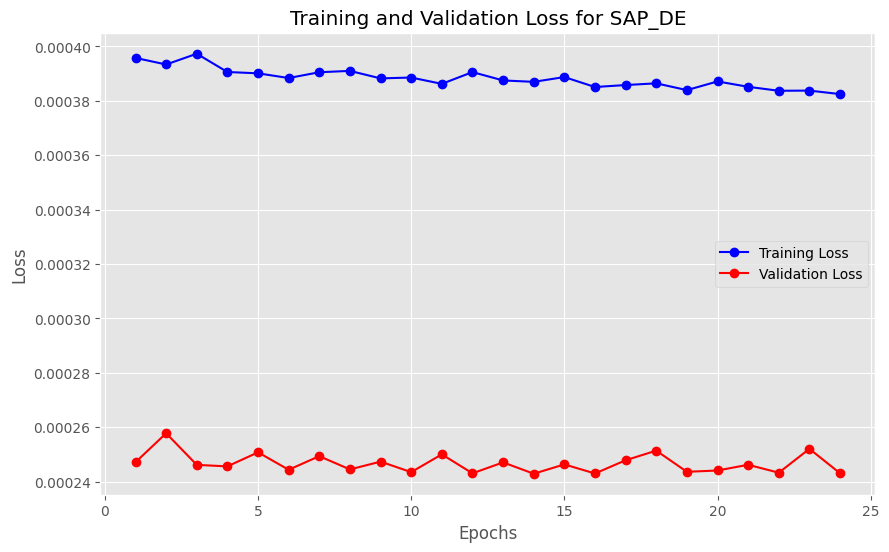

In [47]:
company_name = 'SAP_DE'  # Example company
history_data = results_lstm[company_name]['History']

train_loss = history_data['loss']
val_loss = history_data['val_loss']
epochs_range = range(1, len(train_loss) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title(f'Training and Validation Loss for {company_name}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2.2 ARIMA Model & Prediction

In [48]:
#looking at arima model summary for one stock - SAP
company_name = 'SAP_DE'
model_arima = ARIMA(train_dict_arima[company_name], order=autoarima_dict[company_name].order)  
fitted = model_arima.fit()  
print(fitted.summary())

/Users/cemakkus/PycharmProjects/Master/masterenv_new/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/cemakkus/PycharmProjects/Master/masterenv_new/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/cemakkus/PycharmProjects/Master/masterenv_new/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              1d_return   No. Observations:                  811
Model:                 ARIMA(2, 0, 0)   Log Likelihood                2077.927
Date:                Thu, 14 Mar 2024   AIC                          -4147.853
Time:                        01:40:12   BIC                          -4129.060
Sample:                             0   HQIC                         -4140.638
                                - 811                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        6.03e-05      0.001      0.082      0.935      -0.001       0.002
ar.L1         -0.0580      0.038     -1.524      0.128      -0.132       0.017
ar.L2          0.0785      0.029      2.673      0.0

In [49]:
def arima_model(train_data, test_data, order, output_steps):
    # Fit ARIMA model
    model_arima = ARIMA(train_data, order=order)
    fitted_model = model_arima.fit()
    
    # ARIMA prediction
    history = [x for x in train_data]
    predictions = []
    for t in range(len(test_data)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast(steps=output_steps)
        yhat = output[output_steps - 1]
        predictions.append(yhat)
        obs = test_data[t]
        history.append(obs)
    
    # Flat predictions
    predicted_flat = [float(i) for i in predictions]
    
    # Performance review
    mse = mean_squared_error(test_data, predicted_flat)
    mae = mean_absolute_error(test_data, predicted_flat)
    rmse = math.sqrt(mse)
    
    return mse, mae, rmse, predicted_flat, fitted_model.summary()


In [50]:
warnings.filterwarnings("ignore")

results_arima = {}
for company, train_data in train_dict_arima.items():
    test_data = test_dict_arima[company]
    order = autoarima_dict[company].order
    output_steps = output_steps  # Adjust this if necessary
    
    mse, mae, rmse, predicted_flat, summary = arima_model(train_data, test_data, order, output_steps)
    results_arima[company] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'Predictions': predicted_flat,
        'Summary': summary
    }
    print(f'{company} - MSE: {mse:e}, MAE: {mae:e}, RMSE: {rmse:e}')


ABI_BR - MSE: 1.369522e-04, MAE: 8.613115e-03, RMSE: 1.170266e-02
ADS_DE - MSE: 4.234814e-04, MAE: 1.444448e-02, RMSE: 2.057866e-02
ADYEN_AS - MSE: 1.930041e-03, MAE: 2.039810e-02, RMSE: 4.393224e-02
AD_AS - MSE: 1.236013e-04, MAE: 7.290922e-03, RMSE: 1.111761e-02
AIR_PA - MSE: 1.453416e-04, MAE: 9.129721e-03, RMSE: 1.205577e-02
AI_PA - MSE: 9.657445e-05, MAE: 7.096908e-03, RMSE: 9.827230e-03
ALV_DE - MSE: 1.040372e-04, MAE: 7.128937e-03, RMSE: 1.019986e-02
ASML_AS - MSE: 2.820257e-04, MAE: 1.248797e-02, RMSE: 1.679362e-02
BAS_DE - MSE: 2.469046e-04, MAE: 1.168357e-02, RMSE: 1.571320e-02
BAYN_DE - MSE: 3.567410e-04, MAE: 1.090050e-02, RMSE: 1.888759e-02
BBVA_MC - MSE: 2.110910e-04, MAE: 1.108351e-02, RMSE: 1.452897e-02
BMW_DE - MSE: 2.281275e-04, MAE: 1.060722e-02, RMSE: 1.510389e-02
BNP_PA - MSE: 1.902542e-04, MAE: 1.027868e-02, RMSE: 1.379327e-02
BN_PA - MSE: 7.752661e-05, MAE: 6.744199e-03, RMSE: 8.804919e-03
CRH - MSE: 2.352729e-04, MAE: 1.148949e-02, RMSE: 1.533861e-02
CS_PA - MSE

### 2.3 Comparison between LSTM & ARIMA Predictions - SAP

In [51]:
# Placeholder for storing all companies' comparison results
results_comp = {}

for company in data_dict.keys():
    # Determine the minimum length for comparison across LSTM and ARIMA predictions
    min_comp = min(len(results_lstm[company]['Predictions']), len(results_arima[company]['Predictions']))
    
    # Extract the relevant portions of predictions
    pred_lstm = pd.Series(results_lstm[company]['Predictions'][-min_comp:], index=data_dict[company]['1d_return'].iloc[-min_comp:].index)
    pred_arima = pd.Series(results_arima[company]['Predictions'][-min_comp:], index=data_dict[company]['1d_return'].iloc[-min_comp:].index)
    
    # Assuming Y_test_dict is similarly structured to data_dict and results dicts
    actual = pd.Series(Y_test_dict[company][-min_comp:], index=data_dict[company]['1d_return'].iloc[-min_comp:].index)
    
    # Concatenate actual values and predictions for LSTM and ARIMA into one DataFrame
    predictions = pd.concat([actual, pred_lstm, pred_arima], axis=1, keys=['actual', 'pred_lstm', 'pred_arima'])
    
    # Store the combined DataFrame in the results_comp dictionary
    results_comp[company] = predictions

# Now, results_comp contains the actual values and predictions from both LSTM and ARIMA models for each company.


In [52]:
results_comp['SAP_DE']

,actual,pred_lstm,pred_arima
date,,,
2023-03-31,0.006068,0.003492,0.000064
2023-04-03,-0.003963,0.002148,0.000072
2023-04-04,0.006401,0.002235,0.000078
2023-04-05,-0.000688,0.002698,0.000068
2023-04-06,0.006365,0.002495,0.000081
...,...,...,...
2024-01-11,-0.001126,0.001431,0.000256
2024-01-12,0.021004,0.002749,0.000286
2024-01-15,-0.002071,0.002842,0.000270


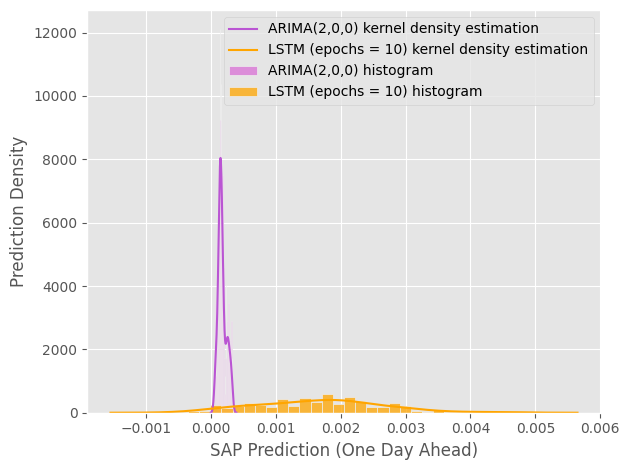

In [53]:
# Setting up the bins parameter for consistency across histograms
bins = 30  # Adjust the number of bins as needed

# ARIMA Histogram
sns.histplot(data=results_comp['SAP_DE'], x='pred_arima', bins=bins, color='orchid', stat='density', label='ARIMA(2,0,0) histogram')

# ARIMA KDE
sns.kdeplot(data=results_comp['SAP_DE'], x='pred_arima', color='mediumorchid', label='ARIMA(2,0,0) kernel density estimation')

# LSTM Histogram
sns.histplot(data=results_comp['SAP_DE'], x='pred_lstm', bins=bins, color='orange', stat='density', label='LSTM (epochs = 10) histogram')

# LSTM KDE
sns.kdeplot(data=results_comp['SAP_DE'], x='pred_lstm', color='orange', label='LSTM (epochs = 10) kernel density estimation')

# Actual Histogram
#sns.histplot(data=results_comp['SAP_DE'], x='actual', bins=bins, color='blue', stat='density', label='Actual histogram')

# Actual KDE
#sns.kdeplot(data=results_comp['SAP_DE'], x='actual', color='blue', label='Actual kernel density estimation')

# Adding labels and adjusting layout
plt.xlabel('SAP Prediction (One Day Ahead)')
plt.ylabel('Prediction Density')
plt.tight_layout()
plt.legend()

# Uncomment the following line if you want to save the figure
#plt.savefig('hist_pred_sap.png')

plt.show()


In [54]:
# #plot - sap asset return predictions
# plt.plot(results_comp['SAP_DE']['actual'][0:50], color= 'blue', label = 'Actual')
# plt.plot(results_comp['SAP_DE']['pred_lstm'][0:50], color= 'orange', label = 'LSTM (epochs = 10)', linewidth = 3)
# plt.plot(results_comp['SAP_DE']['pred_arima'][0:50], color= 'darkorchid', label = 'ARIMA(2,0,0)', linewidth = 3)
# plt.xlabel('Date')
# plt.ylabel('SAP Asset Returns')
# plt.legend()
# plt.tight_layout()
# #plt.savefig('pred_sap_1.png')

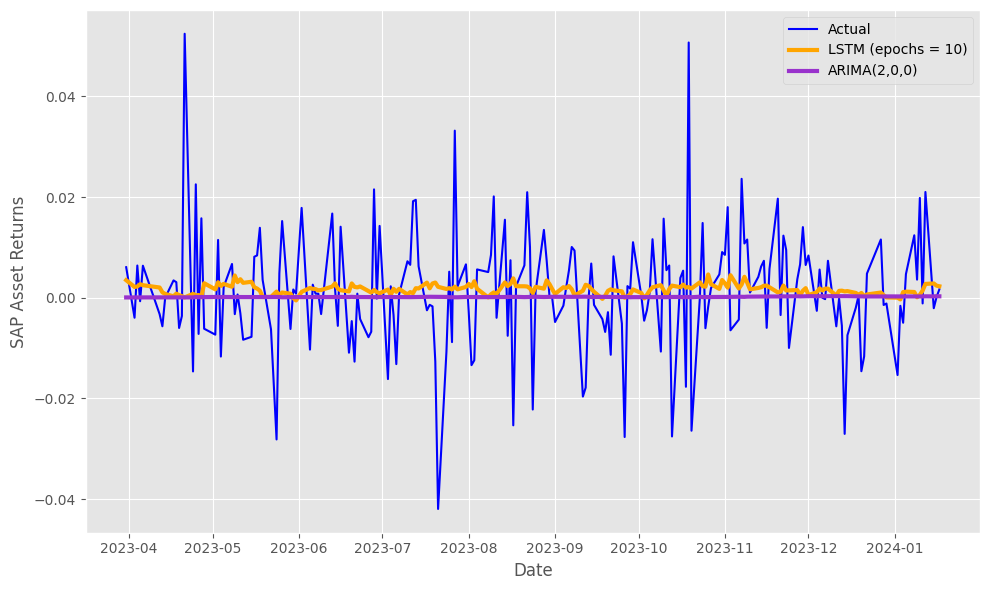

In [55]:
import matplotlib.dates as mdates

# Assuming results_comp['SAP_DE'] has a DateTimeIndex or the date information can be extracted
dates = results_comp['SAP_DE'].index  # Extract the dates corresponding to your data

#plot - sap asset return predictions
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size as needed
plt.plot(dates, results_comp['SAP_DE']['actual'], color='blue', label='Actual')
plt.plot(dates, results_comp['SAP_DE']['pred_lstm'], color='orange', label='LSTM (epochs = 10)', linewidth=3)
plt.plot(dates, results_comp['SAP_DE']['pred_arima'], color='darkorchid', label='ARIMA(2,0,0)', linewidth=3)

# Set major ticks format
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Show one label per month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as Year-Month
#plt.gcf().autofmt_xdate()  # Auto-format date labels for better readability

plt.xlabel('Date')
plt.ylabel('SAP Asset Returns')
plt.legend()
plt.tight_layout()

plt.show()

In [56]:
def calculate_metrics_comp(results_comp):
    metrics_comp = {}
    
    for company in results_comp.keys():
        # Initialize counters
        metrics = {'tp_arima': 0, 'fp_arima': 0, 'tn_arima': 0, 'fn_arima': 0,
                   'tp_lstm': 0, 'fp_lstm': 0, 'tn_lstm': 0, 'fn_lstm': 0}
        
        # Derive sign columns
        actual_sign = ['Pos' if val >= 0 else 'Neg' for val in results_comp[company]['actual']]
        pred_arima_sign = ['Pos' if val >= 0 else 'Neg' for val in results_comp[company]['pred_arima']]
        pred_lstm_sign = ['Pos' if val >= 0 else 'Neg' for val in results_comp[company]['pred_lstm']]
        
        # Calculate confusion matrix for ARIMA and LSTM
        for actual, pred_arima, pred_lstm in zip(actual_sign, pred_arima_sign, pred_lstm_sign):
            if actual == 'Pos' and pred_arima == 'Pos':
                metrics['tp_arima'] += 1
            elif actual == 'Pos' and pred_arima == 'Neg':
                metrics['fn_arima'] += 1
            elif actual == 'Neg' and pred_arima == 'Neg':
                metrics['tn_arima'] += 1
            else:
                metrics['fp_arima'] += 1
                
            if actual == 'Pos' and pred_lstm == 'Pos':
                metrics['tp_lstm'] += 1
            elif actual == 'Pos' and pred_lstm == 'Neg':
                metrics['fn_lstm'] += 1
            elif actual == 'Neg' and pred_lstm == 'Neg':
                metrics['tn_lstm'] += 1
            else:
                metrics['fp_lstm'] += 1
        
        # Function to calculate precision, recall, F1 score, and accuracy
        def calculate_metrics(tp, fp, fn, tn):
            precision = round(tp / (tp + fp) if (tp + fp) else 0, 4)
            recall = round(tp / (tp + fn) if (tp + fn) else 0, 4)
            f1 = round(2 * (precision * recall) / (precision + recall) if (precision + recall) else 0, 4)
            accuracy = round((tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) else 0, 4)
            return precision, recall, f1, accuracy
        
        # Calculate metrics for ARIMA
        precision_arima, recall_arima, f1_arima, accuracy_arima = calculate_metrics(metrics['tp_arima'], metrics['fp_arima'], metrics['fn_arima'], metrics['tn_arima'])
        
        # Calculate metrics for LSTM
        precision_lstm, recall_lstm, f1_lstm, accuracy_lstm = calculate_metrics(metrics['tp_lstm'], metrics['fp_lstm'], metrics['fn_lstm'], metrics['tn_lstm'])
        
        # Store metrics
        metrics_comp[company] = {
            'ARIMA': {'TP': metrics['tp_arima'], 'FP': metrics['fp_arima'], 'TN': metrics['tn_arima'], 'FN': metrics['fn_arima'],
                      'Precision': precision_arima, 'Recall': recall_arima, 'F1': f1_arima, 'Accuracy': accuracy_arima},
            'LSTM': {'TP': metrics['tp_lstm'], 'FP': metrics['fp_lstm'], 'TN': metrics['tn_lstm'], 'FN': metrics['fn_lstm'],
                     'Precision': precision_lstm, 'Recall': recall_lstm, 'F1': f1_lstm, 'Accuracy': accuracy_lstm}
        }
        
    return metrics_comp

# Assuming results_comp has been populated as in previous examples
# metrics_comp = calculate_metrics_comp(results_comp)
# This will calculate and store Precision, Recall, F1 Score, and Accuracy for each company, for both ARIMA and LSTM models.


In [57]:
metrics_comp = calculate_metrics_comp(results_comp)

# Loop over all companies in metrics_comp to print their metrics
for company, metrics in metrics_comp.items():
    print(f"Metrics for {company} - ARIMA:")
    print(metrics['ARIMA'])
    print(f"Metrics for {company} - LSTM:")
    print(metrics['LSTM'])
    print("\n")  # Adds a newline for better readability between companies


Metrics for ABI_BR - ARIMA:
{'TP': 33, 'FP': 29, 'TN': 65, 'FN': 74, 'Precision': 0.5323, 'Recall': 0.3084, 'F1': 0.3905, 'Accuracy': 0.4876}
Metrics for ABI_BR - LSTM:
{'TP': 19, 'FP': 9, 'TN': 85, 'FN': 88, 'Precision': 0.6786, 'Recall': 0.1776, 'F1': 0.2815, 'Accuracy': 0.5174}


Metrics for ADS_DE - ARIMA:
{'TP': 0, 'FP': 0, 'TN': 103, 'FN': 95, 'Precision': 0, 'Recall': 0.0, 'F1': 0, 'Accuracy': 0.5202}
Metrics for ADS_DE - LSTM:
{'TP': 6, 'FP': 3, 'TN': 100, 'FN': 89, 'Precision': 0.6667, 'Recall': 0.0632, 'F1': 0.1155, 'Accuracy': 0.5354}


Metrics for ADYEN_AS - ARIMA:
{'TP': 101, 'FP': 100, 'TN': 0, 'FN': 0, 'Precision': 0.5025, 'Recall': 1.0, 'F1': 0.6689, 'Accuracy': 0.5025}
Metrics for ADYEN_AS - LSTM:
{'TP': 18, 'FP': 12, 'TN': 88, 'FN': 83, 'Precision': 0.6, 'Recall': 0.1782, 'F1': 0.2748, 'Accuracy': 0.5274}


Metrics for AD_AS - ARIMA:
{'TP': 106, 'FP': 95, 'TN': 0, 'FN': 0, 'Precision': 0.5274, 'Recall': 1.0, 'F1': 0.6906, 'Accuracy': 0.5274}
Metrics for AD_AS - LSTM:
